In [27]:
%load_ext autoreload
%autoreload
%matplotlib widget
from N_xi_fit_funcs import *
import phaseco as pc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate, get_window, convolve, correlation_lags
from scipy.optimize import curve_fit
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Directories
os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence")
pkl_folder = r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles"

In [35]:
# Get waveform
wf_idx = 2
species = "Owl"
wf_len_s = 1
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)
wf = crop_wf(wf, fs, wf_len_s)
f0 = good_peak_freqs[1]

In [91]:
# Get colossogram
win_type = 'flattop'
win_meth = {'method':'static', 'win_type':win_type}
bw = 200
pw=True
tau = get_precalc_tau_from_bw(bw, fs, win_type)
nfft = tau
hop = 0.1
xis = {
    'xi_min_s':0.001,
    'xi_max_s':0.1,
    'delta_xi_s':0.001
}
f0s = [f0]
cgram_dict = load_calc_colossogram(
    **{
        "wf": wf,
        "wf_idx": wf_idx,
        "wf_fn": wf_fn,
        "wf_len_s": wf_len_s,
        "wf_pp": None,
        "species": species,
        "fs": fs,
        "filter_meth": None,
        "pkl_folder": pkl_folder,
        "pw": pw,
        "tau": tau,
        "nfft": nfft,
        "xi_min_s": xis['xi_min_s'],
        "xi_max_s": xis['xi_max_s'],
        "hop": hop,
        "win_meth": win_meth,
        "force_recalc_colossogram": 0,
        "plot_what_we_got": 0,
        "only_calc_new_coherences": 0,
        "const_N_pd": 0,
        "scale": True,
        "N_bs": 0,
        "f0s": f0s,
    }
)
f = cgram_dict['f']
f0_exact = f[np.argmin(np.abs(f-f0))]

hi
Processing C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles\Owl 2, PW=True, Static Flattop, hop=82, tau=821, filter=None, xi_max=100ms, nfft=821, f0s=[8096], N_pd=max, wf_len=1s, wf=TAG6rearSOAEwf1 (Colossogram).pkl


In [92]:
"Plot colosogram"
# pc.plot_colossogram(cgram_dict['xis_s'], cgram_dict['f'], cgram_dict['colossogram'])
# plt.xlim(None, 20)
# plt.ylim(3, 12)

'Plot colosogram'

In [93]:
"Get single narrowband around f0"
win_type = 'flattop'
win = get_window(win_type, tau)
omega_0_norm = f0_exact * 2*np.pi / fs
kernel = win * np.exp(1j * omega_0_norm * np.arange(len(win)))
wf_filtered = convolve(wf, kernel, mode='valid', method='fft')
acf = correlate(wf_filtered, wf_filtered, mode='full', method='auto')
N = len(wf_filtered)
lags = correlation_lags(N, N, mode='full')
lags_ms = lags / fs * 1000
mid_idx = len(lags)//2
acf_norm = np.abs(acf)/np.abs(acf[mid_idx])
print(np.min(acf_norm))

1.5017951110577356e-05


[FITTING 8111Hz AUTOCOHERENCE DECAY]
One peak found in first 26ms of xi, starting fit here
Fitting...
Fit succeeded on first try!


c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


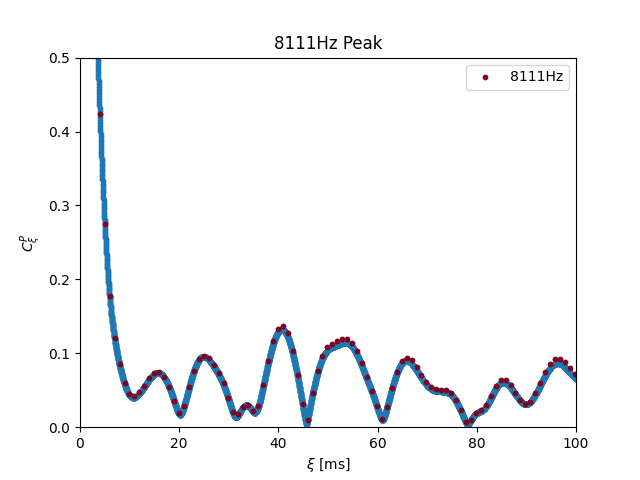

In [ ]:
plt.close('all')
plt.figure()
plt.scatter(lags_ms[mid_idx:], acf_norm[mid_idx:], s=10)
# N_xi, N_xi_dict = pc.get_N_xi(cgram_dict, f0)
# pc.plot_N_xi_fit(N_xi_dict, plot_noise_floor=False, plot_fit=False)
plt.xlim(0, 100)
plt.ylim(0, 0.5)
plt.show()